In [ ]:
pip install stockstats

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from tqdm import tqdm
import pywt
from stockstats import StockDataFrame as Sdf
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from pandas.tseries.offsets import CustomBusinessDay, DateOffset, WeekOfMonth
from pandas.tseries.holiday import sunday_to_monday, AbstractHolidayCalendar, Holiday, USMemorialDay, USLaborDay, USColumbusDay, USThanksgivingDay
import math
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})

# I. Study of the data

## 1. Data processing

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1ATmaZrLwm1_hE1I1p7s2S1rjpLXv1ozx'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.xlsx')  

df_BcBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan BC')
df_BcBalance.set_index('Date', inplace = True, drop = True)
df_BcBalance = df_BcBalance.resample('D').fillna(method = 'ffill')

df_daily_data = pd.read_excel("dataset.xlsx", sheet_name = 'Données journalières')
df_daily_data.set_index('Date', inplace = True, drop = True)
del df_daily_data['CRB - Bétail']

df_EconomicalSurprise = pd.read_excel("dataset.xlsx", sheet_name = 'Surprise économique')
df_EconomicalSurprise.set_index('Date', inplace = True, drop = True)
df_EconomicalSurprise = df_EconomicalSurprise.resample('D').fillna(method = 'ffill')

df_FedBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan FED')
df_FedBalance.set_index('Date', inplace = True, drop = True)
df_FedBalance = df_FedBalance.resample('D').fillna(method = 'ffill')

df_gold = pd.read_excel("dataset.xlsx", sheet_name = 'Or')
df_gold.set_index('Date', inplace = True, drop = True)
df_gold = df_gold.resample('D').fillna(method = 'ffill')

df_InflationUnemployment = pd.read_excel("dataset.xlsx", sheet_name = 'Chômage & Inflation')
df_InflationUnemployment.set_index('Date', inplace = True, drop = True)
df_InflationUnemployment = df_InflationUnemployment.resample('D').fillna(method = 'ffill')

df_oil = pd.read_excel("dataset.xlsx", sheet_name = 'Pétrole')
df_oil.set_index('Date', inplace = True, drop = True)
df_oil = df_oil.resample('D').fillna(method = 'ffill')

df_ProductionCapacity = pd.read_excel("dataset.xlsx", sheet_name = 'Capacité de production')
df_ProductionCapacity.set_index('Date', inplace = True, drop = True)
df_ProductionCapacity = df_ProductionCapacity.resample('D').fillna(method = 'ffill')

df_SPX = pd.DataFrame(df_daily_data['SPX Index'].copy())
df_SPX.index = df_daily_data.index.copy()
#del df_daily_data['SPX Index']

df_daily_data = df_daily_data.join(df_BcBalance).join(df_EconomicalSurprise).join(df_gold).join(df_InflationUnemployment).join(df_ProductionCapacity)
df_daily_data = df_daily_data[(df_daily_data.index >= '2000-12-31') & (df_daily_data.index <= '2019-12-31')]

df_SPX = pd.DataFrame(df_daily_data['SPX Index'].copy())
df_SPX.index = df_daily_data.index.copy()
#del df_daily_data['SPX Index']
#df_daily_data['Weekday'] = df_daily_data.index.dayofweek
#df_daily_data = df_daily_data[df_daily_data.Weekday <= 4]
df_daily_data.head(10)

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index
Date,,,,,,,,,,,,,,,,,,
2000-12-31,0.00,26.85,3.0,5.112,6.5,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-01,0.00,26.85,3.0,5.114,6.5,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-02,-2.80,29.99,3.0,4.915,6.5,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609
2001-01-03,5.01,26.60,3.0,5.158,6.0,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609
2001-01-04,-1.06,26.97,3.0,5.039,6.0,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609
2001-01-05,-2.62,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-06,0.00,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,0.000000,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-07,0.00,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,0.000000,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-08,-0.19,29.84,3.0,4.956,6.0,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609


In [ ]:
def compute_price(df):
  df['Closing Price'] = 1320.28*(1+df['SPX Index'].copy()/100).cumprod()
  return df

In [ ]:
df_daily_data = compute_price(df_daily_data)

In [ ]:
scale = 0.05
coefficients = pywt.wavedec(df_daily_data['Closing Price'], 'coif3', mode = 'smooth')
coefficients[1:] = [pywt.threshold(i, value = scale * df_daily_data['Closing Price'].max(), mode = 'garotte') for i in coefficients[1:]]
reconstructed_SPX = pywt.waverec(coefficients, 'coif3', mode = 'smooth')
reconstructed_SPX = pd.DataFrame(reconstructed_SPX, columns=['Closing Price'], index=df_daily_data.index)

In [ ]:
df_daily_data['Wavelet_price'] = reconstructed_SPX['Closing Price']

Denoised

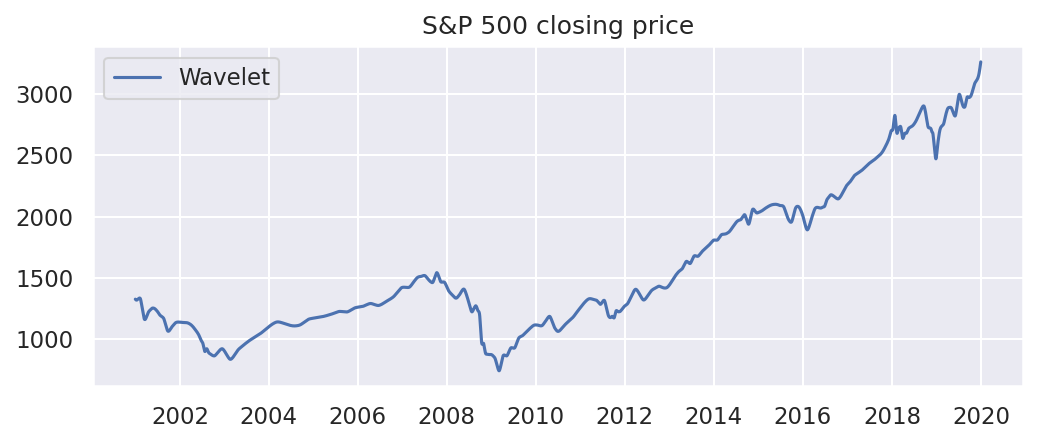

In [ ]:
plt.figure(figsize=(8,3), dpi=150)
plt.plot(df_daily_data['Wavelet_price'], label='Wavelet')
plt.title("S&P 500 closing price")
plt.legend()
plt.show()#

In [ ]:
start = dt.datetime(2000, 12, 31)
end = dt.datetime(2019, 12, 31)

df_SPX_stocks = web.DataReader(['^GSPC'], 'yahoo', start, end)
df_SPX_stocks.columns = ['Ajd Close', 'Close', 'High', 'Low' ,'Open', 'Volume']
df_SPX_stocks

,Ajd Close,Close,High,Low,Open,Volume
Date,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000
...,...,...,...,...,...,...
2019-12-24,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000
2019-12-26,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000
2019-12-27,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000


In [ ]:
stock_df = Sdf.retype(df_SPX_stocks)
df_SPX_stocks['rsi']=stock_df['rsi_14']
del df_SPX_stocks['close_-1_s']
del df_SPX_stocks['close_-1_d']
del df_SPX_stocks['rs_14']
del df_SPX_stocks['rsi_14']
del df_SPX_stocks['closepm']
del df_SPX_stocks['closenm']
del df_SPX_stocks['closepm_14_smma']
del df_SPX_stocks['closenm_14_smma']

In [ ]:
df_SPX_stocks['CCI']=stock_df['cci']
df_SPX_stocks['STCK%']=stock_df['kdjk']
df_SPX_stocks['ADO'] = (df_SPX_stocks['high'] - df_SPX_stocks['close'])/(df_SPX_stocks['high']-df_SPX_stocks['low'])

In [ ]:
df_SPX_stocks.head()

,ajd close,close,high,low,open,volume,rsi,CCI,STCK%,ADO
Date,,,,,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874


## Compute Indicators

In [ ]:
class BankCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=sunday_to_monday),
        Holiday("Martin Luther King Jr.'s Birthday", month=1, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        Holiday("Washington's Birthday", month=2, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        USMemorialDay,
        Holiday("Independence Day", month=7, day=4, observance=sunday_to_monday),
        USLaborDay,
        USColumbusDay,
        Holiday("Veteran's Day", month=11, day=11, observance=sunday_to_monday),
        USThanksgivingDay,
        Holiday("Christmas Day", month=12, day=25, observance=sunday_to_monday),
    ]

In [ ]:
# Keep only bank business days
Bank_business_days = CustomBusinessDay(calendar = BankCalendar())
business_days = pd.date_range('2000-12-31', end = '2019-12-31', freq = Bank_business_days)
df_business_days = pd.DataFrame(business_days, columns = ['Date'])
df_business_days.set_index('Date', inplace = True, drop = True)
df_daily_data = df_daily_data.join(df_business_days, how = 'right')

In [ ]:
df_daily_data = df_daily_data.merge(df_SPX_stocks, how='inner', on='Date')

In [ ]:
df_daily_data

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index,Closing Price,Wavelet_price,ajd close,close,high,low,open,volume,rsi,CCI,STCK%,ADO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-02,-2.80,29.99,3.0,4.9150,6.50,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609,1283.312160,1323.684764,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,5.01,26.60,3.0,5.1580,6.00,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609,1347.606099,1322.631438,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,-1.06,26.97,3.0,5.0390,6.00,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609,1333.321475,1321.625674,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,-2.62,28.67,3.0,4.9310,6.00,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1298.388452,1320.715967,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,-0.19,29.84,3.0,4.9560,6.00,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1295.921514,1318.540458,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.02,12.67,2.1,1.8996,1.75,398.81,757.07,451.23,333.39,280.42,34.643269,18.8,0.138,1499.1,3.5,126.80,2.1,77.5723,3218.999205,3212.387388,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000,75.832040,101.064316,94.748484,0.515218
2019-12-26,0.51,12.65,2.1,1.8944,1.75,399.49,758.45,451.60,334.39,280.52,36.152876,18.8,0.138,1509.3,3.5,126.80,2.1,77.5723,3235.416101,3226.187217,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000,78.415059,113.069057,96.431116,0.013212
2019-12-27,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,36.932393,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723,3235.416101,3233.339941,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000,78.431595,111.731236,93.520222,0.583335


In [ ]:
def exponential_smooth(data, alpha):
  return data.ewm(alpha=alpha).mean()

df_daily_data['Smooth_price'] = exponential_smooth(df_daily_data['close'], 0.65)

In [ ]:
df_relevant_indicators = df_daily_data[['SPX Index', 'FDTR Index', 'Vix Index', 'Surprise économique', 'Inflation US', 'Confiance des consommateurs US', 'Taux 10 ans US', 'close','open', 'high', 'low', 'Wavelet_price', 'MACD', 'rsi',	'CCI',	'STCK%',	'ADO']]
df_relevant_indicators.head(5)

,SPX Index,FDTR Index,Vix Index,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,close,open,high,low,Wavelet_price,MACD,rsi,CCI,STCK%,ADO
Date,,,,,,,,,,,,,,,,,
2001-01-02,-2.80,6.5,29.99,-0.218,3.4,128.55,4.915,1283.270020,1320.280029,1320.280029,1276.050049,1323.684764,-15.078643,NaN,NaN,38.774568,0.836763
2001-01-03,5.01,6.0,26.60,-0.218,3.4,128.55,5.158,1347.560059,1283.270020,1347.760010,1274.619995,1322.631438,-11.375763,100.000000,66.666667,59.091918,0.002734
2001-01-04,-1.06,6.0,26.97,-0.218,3.4,128.55,5.039,1333.339966,1347.560059,1350.239990,1329.140015,1321.625674,-9.479367,80.762337,78.716507,65.278406,0.800950
2001-01-05,-2.62,6.0,28.67,-0.218,3.4,128.55,4.931,1298.349976,1333.339966,1334.770020,1294.949951,1320.715967,-10.676785,53.492969,-29.735146,53.979125,0.914615
2001-01-08,-0.19,6.0,29.84,-0.218,3.4,128.55,4.956,1295.859985,1298.349976,1298.349976,1276.290039,1318.540458,-11.691893,52.143676,-86.857456,45.348682,0.112874


In [ ]:
df_trends_indicator = df_relevant_indicators[['close', 'rsi', 'MACD', 'CCI', 'STCK%', 'ADO']]
df_trends_indicator.head()

,close,rsi,MACD,CCI,STCK%,ADO
Date,,,,,,
2001-01-02,1283.270020,NaN,-15.078643,NaN,38.774568,0.836763
2001-01-03,1347.560059,100.000000,-11.375763,66.666667,59.091918,0.002734
2001-01-04,1333.339966,80.762337,-9.479367,78.716507,65.278406,0.800950
2001-01-05,1298.349976,53.492969,-10.676785,-29.735146,53.979125,0.914615
2001-01-08,1295.859985,52.143676,-11.691893,-86.857456,45.348682,0.112874


In [ ]:
np.random.seed(7)

# II. Trends modeling

In [ ]:
def trends_model_difference(df, trends_window):
  n = len(df)
  trends = []
  trends_date = []
  for i in range(0, n - trends_window + 1 ):
    if df[i + trends_window - 1] - df[i] > 0 :
      trends.append(1)
    else :
      trends.append(0)
  if len(trends) == 1:
    return trends[0]
  else :
    return trends

In [ ]:
def ado_stck_macd_trends(data, name):
  indicator = [None]
  for i in range(len(data) - 1):
    if data[name][i+1] > data[name][i]:
      indicator.append(1)
    else:
      indicator.append(0)
  return indicator

In [ ]:
df_trends_indicator['ADO_trends'] = ado_stck_macd_trends(df_trends_indicator, 'ADO')
df_trends_indicator['STCK%_trends'] = ado_stck_macd_trends(df_trends_indicator, 'STCK%')
df_trends_indicator['MACD_trends'] = ado_stck_macd_trends(df_trends_indicator, 'MACD')

In [ ]:
def rsi_to_trends(data, name):
  rsi_trends = [None]
  for i in range(len(data) - 1):
    if data[name][i + 1] > 70:
      rsi_trends.append(0)
    elif data[name][i + 1] < 30:
      rsi_trends.append(1)
    else:
      if data[name][i+1] > data[name][i]:
        rsi_trends.append(1)
      else:
        rsi_trends.append(0)
  return rsi_trends

In [ ]:
df_trends_indicator['rsi_trends'] = rsi_to_trends(df_trends_indicator, 'rsi')
df_trends_indicator.head()

,close,rsi,MACD,CCI,STCK%,ADO,ADO_trends,STCK%_trends,MACD_trends,rsi_trends
Date,,,,,,,,,,
2001-01-02,1283.270020,NaN,-15.078643,NaN,38.774568,0.836763,NaN,NaN,NaN,NaN
2001-01-03,1347.560059,100.000000,-11.375763,66.666667,59.091918,0.002734,0.0,1.0,1.0,0.0
2001-01-04,1333.339966,80.762337,-9.479367,78.716507,65.278406,0.800950,1.0,1.0,1.0,0.0
2001-01-05,1298.349976,53.492969,-10.676785,-29.735146,53.979125,0.914615,1.0,0.0,0.0,0.0
2001-01-08,1295.859985,52.143676,-11.691893,-86.857456,45.348682,0.112874,0.0,0.0,0.0,0.0


In [ ]:
def cci_to_trends(data, name):
  cci_trends = [None]
  for i in range(len(data) - 1):
    if data[name][i + 1] > 200:
      cci_trends.append(0)
    elif data[name][i + 1] < -200:
      cci_trends.append(1)
    else:
      if data[name][i+1] > data[name][i]:
        cci_trends.append(1)
      else:
        cci_trends.append(0)
  return cci_trends

In [ ]:
df_trends_indicator['cci_trends'] = cci_to_trends(df_trends_indicator, 'CCI')

In [ ]:
df_trends_indicator = df_trends_indicator[1:]

In [ ]:
df_trends_indicator.head(20)

,close,rsi,MACD,CCI,STCK%,ADO,ADO_trends,STCK%_trends,MACD_trends,rsi_trends,cci_trends
Date,,,,,,,,,,,
2001-01-03,1347.560059,100.000000,-11.375763,66.666667,59.091918,0.002734,0.0,1.0,1.0,0.0,0.0
2001-01-04,1333.339966,80.762337,-9.479367,78.716507,65.278406,0.800950,1.0,1.0,1.0,0.0,1.0
2001-01-05,1298.349976,53.492969,-10.676785,-29.735146,53.979125,0.914615,1.0,0.0,0.0,0.0,0.0
2001-01-08,1295.859985,52.143676,-11.691893,-86.857456,45.348682,0.112874,0.0,0.0,0.0,0.0,0.0
2001-01-09,1300.800049,54.590891,-11.959890,-32.288047,41.772636,0.658622,1.0,0.0,0.0,1.0,1.0
2001-01-10,1313.270020,60.132876,-11.038807,-20.805097,44.885375,0.018504,0.0,1.0,1.0,1.0,1.0
2001-01-11,1326.819946,65.115028,-9.110450,63.308543,52.933349,0.238985,1.0,1.0,1.0,1.0,1.0
2001-01-12,1318.550049,60.172512,-8.173869,48.680341,54.653290,0.678072,1.0,1.0,1.0,0.0,0.0
2001-01-16,1326.650024,63.124868,-6.682430,51.471103,59.370391,0.080112,0.0,1.0,1.0,1.0,1.0


In [ ]:
df_sample = df_relevant_indicators[['SPX Index', 'FDTR Index', 'Wavelet_price', 'Vix Index','Surprise économique', 'Inflation US', 'Confiance des consommateurs US', 'MACD']][1:]
df_sample.head(20)

,SPX Index,FDTR Index,Wavelet_price,Vix Index,Surprise économique,Inflation US,Confiance des consommateurs US,MACD
Date,,,,,,,,
2001-01-03,5.01,6.0,1322.631438,26.60,-0.218,3.4,128.55,-11.375763
2001-01-04,-1.06,6.0,1321.625674,26.97,-0.218,3.4,128.55,-9.479367
2001-01-05,-2.62,6.0,1320.715967,28.67,-0.218,3.4,128.55,-10.676785
2001-01-08,-0.19,6.0,1318.540458,29.84,-0.218,3.4,128.55,-11.691893
2001-01-09,0.38,6.0,1318.107001,27.99,-0.218,3.4,128.55,-11.959890
2001-01-10,0.96,6.0,1317.916065,26.80,-0.218,3.4,128.55,-11.038807
2001-01-11,1.03,6.0,1318.054450,25.79,-0.218,3.4,128.55,-9.110450
2001-01-12,-0.64,6.0,1318.444856,24.56,-0.218,3.4,128.55,-8.173869
2001-01-16,0.63,6.0,1321.445650,25.28,-0.218,3.4,128.55,-6.682430


In [ ]:
def create_data(X, Y, time_step):
  X_lagged, Y_lagged = [], []
  for i in range(len(X) - time_step):
    sxp = X['SPX Index'][i: i + time_step]
    fed = X['FDTR Index'][i: i + time_step]
    spe = X['Surprise économique'][i: i + time_step]
    vix = X['Vix Index'][i: i + time_step]
    close = X['Wavelet_price'][i: i + time_step]
    close = (close - close.min()) / (close.max() - close.min())
    inf = X['Inflation US'][i: i + time_step]
    confiance = X['Confiance des consommateurs US'][i: i + time_step]
    confiance = (confiance - confiance.min()) / (confiance.max() - confiance.min())
    macd = X['MACD'][i: i + time_step]
    macd = (macd - macd.min()) / (macd.max() - macd.min())
    stacked_col = np.column_stack((fed, spe, vix, close, confiance, inf))
    X_lagged.append(stacked_col)
    Y_lagged.append(Y[i + time_step])
  return np.array(X_lagged), np.array(Y_lagged)

In [ ]:
n_train = int(0.8*len(df_sample))
time_step_1 = 60
trends_model = 'STCK%_trends'
X_train_1 , Y_train_1 = df_sample[:n_train], df_trends_indicator[trends_model][:n_train].values
X_train_lagged_1 , Y_train_lagged_1 = create_data(X_train_1, Y_train_1, time_step_1)

In [ ]:
X_test_1, Y_test_1 = df_sample[n_train:], df_trends_indicator[trends_model][n_train:].values
X_test_lagged_1, Y_test_lagged_1 = create_data(X_test_1, Y_test_1, time_step_1)

Build model

In [ ]:
from tensorflow import keras

model_id1 = '1c-qUhV6IR7wZ3TJ3WpQg4tlFHw-9Swla'
downloaded_model = drive.CreateFile({'id':model_id1}) 
downloaded_model.GetContentFile('model_stck_75_epochs_batch64.h5')

model = keras.models.load_model('model_stck_75_epochs_batch64.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
actual_label, actual_label_count = np.unique(Y_test_lagged_1, return_counts=True)
data_dict = dict(zip(actual_label, actual_label_count))

print('Actual labels: ', dict(zip(actual_label, actual_label_count)))
print(' ')
forecast_proba = model.predict(X_test_lagged_1)
forecasted_labels = np.argmax(forecast_proba, axis=1)
get_confusion_matrix  = confusion_matrix(Y_test_lagged_1, forecasted_labels)

predicted_labels, predicted_label_counts = np.unique(forecasted_labels, return_counts=True)
print('Predicted labels: ', dict(zip(predicted_labels, predicted_label_counts)))
print(' ')
print('Confusion matrix of predicted data:')
print(pd.DataFrame(get_confusion_matrix))
print(' ')

for i in range(len(predicted_labels)):
    print('Label {0} accuracy: {1:0.1f}%'.format(i, 100 * get_confusion_matrix[i,i]/actual_label_count[i]))

Actual labels:  {0.0: 414, 1.0: 467}
 
Predicted labels:  {0: 451, 1: 430}
 
Confusion matrix of predicted data:
     0    1
0  291  123
1  160  307
 
Label 0 accuracy: 70.3%
Label 1 accuracy: 65.7%


In [ ]:
forecast_proba

array([[0.8536517 , 0.14634837],
       [0.41280833, 0.5871917 ],
       [0.24569033, 0.75430965],
       ...,
       [0.6822651 , 0.31773487],
       [0.6857348 , 0.31426525],
       [0.7964866 , 0.20351338]], dtype=float32)

In [ ]:
from sklearn import metrics
#fpr, tpr, thresholds = metrics.roc_curve(Y_test_lagged_1, forecast_proba[:,1])
#auc = metrics.roc_auc_score(Y_test_lagged_1, forecast_proba[:,1])

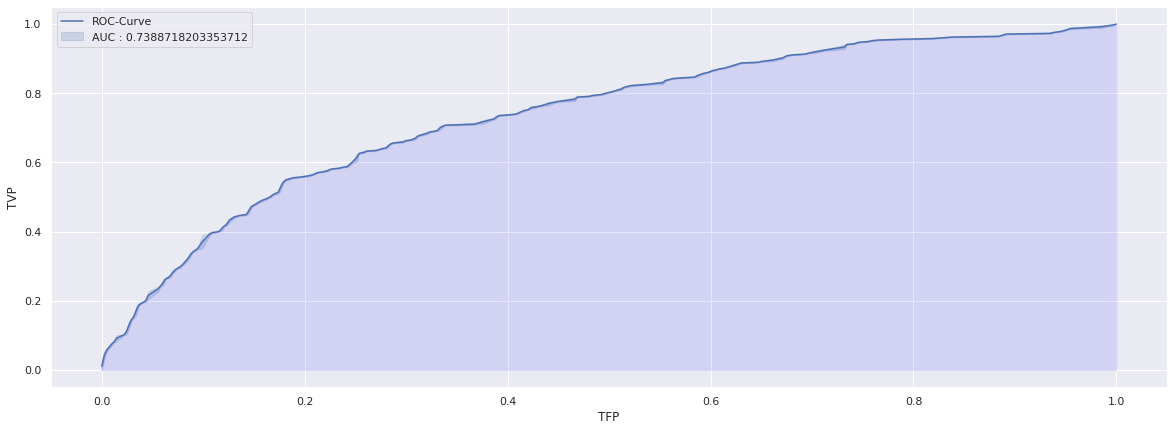

In [ ]:
df_roc_trends_window_1 = pd.DataFrame()
df_roc_trends_window_1['TFP'], df_roc_trends_window_1['TVP'], thresholds = metrics.roc_curve(Y_test_lagged_1, forecast_proba[:,1])
auc = metrics.roc_auc_score(Y_test_lagged_1, forecast_proba[:,1])
fig = sns.lineplot(x = df_roc_trends_window_1['TFP'], y = df_roc_trends_window_1['TVP'])
fig.fill_between(fig.lines[0].get_xydata()[:,0] , fig.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
fig.legend(labels = ['ROC-Curve', 'AUC : ' + str(auc)])

In [ ]:
df_spx = df_relevant_indicators[['SPX Index']][1:]

In [ ]:
y = []
for i in range(len(df_spx['SPX Index'][n_train:]) - time_step_1):
  y.append(df_spx['SPX Index'][n_train:][i + time_step_1])
y = np.array(y)

In [ ]:
base = 100
df = pd.DataFrame({'SXP Index' : y, 'LSTM' : forecasted_labels, 'Optimal': Y_test_lagged_1, 'LSTM_prob': forecast_proba[:,1]})
df['LSTMr'] = df['SXP Index'] * df['LSTM']
df['Closing Price'] = base * (1 + df['SXP Index'].copy()/100).cumprod()
df['Closing Price Bot'] = base * (1 + df['LSTMr'].copy()/100).cumprod()
df['LSTMth'] = df['SXP Index'] * df['Optimal']
df['Closing Price Bot th'] = base * (1 + df['LSTMth'].copy()/100).cumprod()

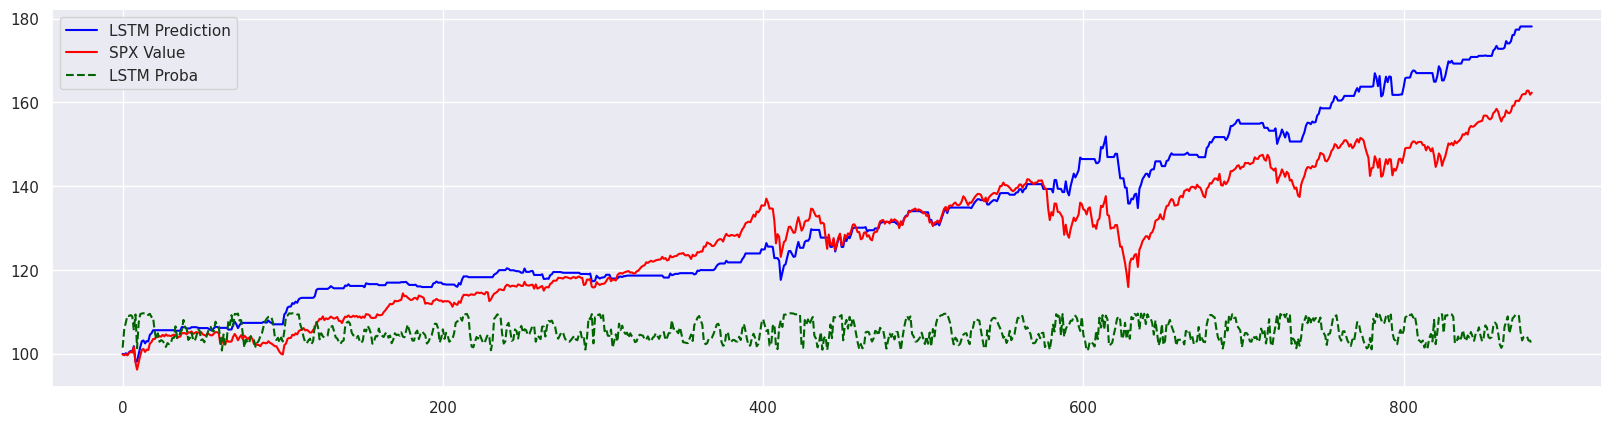

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
plt.plot(df['Closing Price Bot'], color = 'blue', label = 'LSTM Prediction')
plt.plot(df['Closing Price'], color = 'red', label = 'SPX Value')

#plt.plot(df['Closing Price Bot th'], color = 'green', label = 'SPX Value')
#plt.plot((df.Optimal * 10) + 90,'r--', color = 'darkgreen', label = 'B/S Indicator')
plt.plot((df.LSTM_prob * 10) + 100,'r--', color = 'darkgreen', label = 'LSTM Proba')
plt.legend()
plt.show()

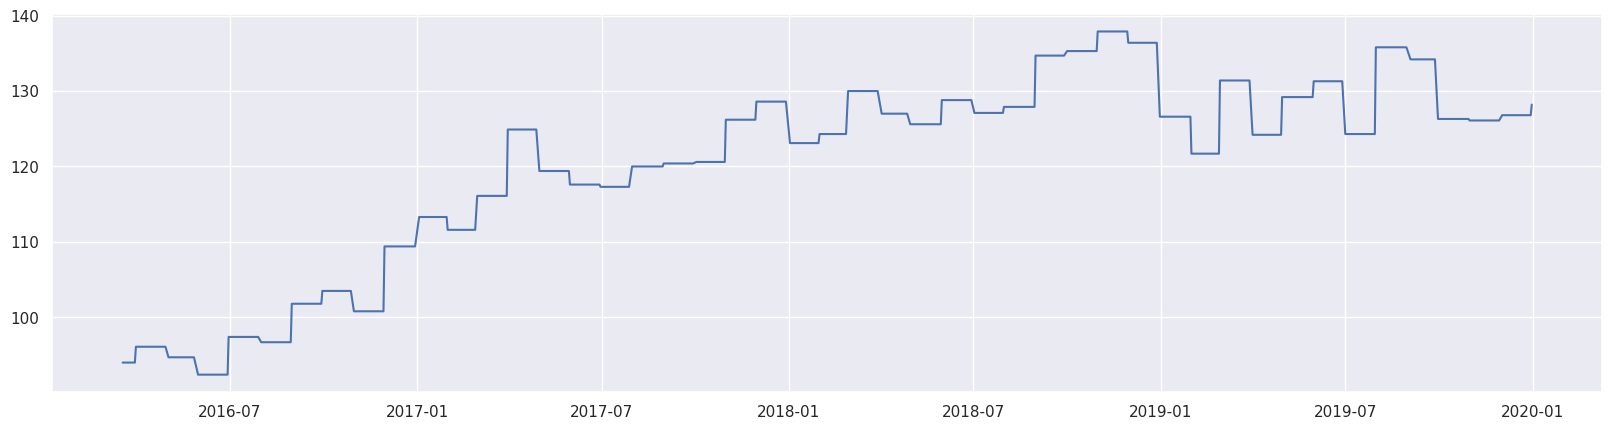

In [ ]:
plt.plot(df_sample['Confiance des consommateurs US'][n_train:])

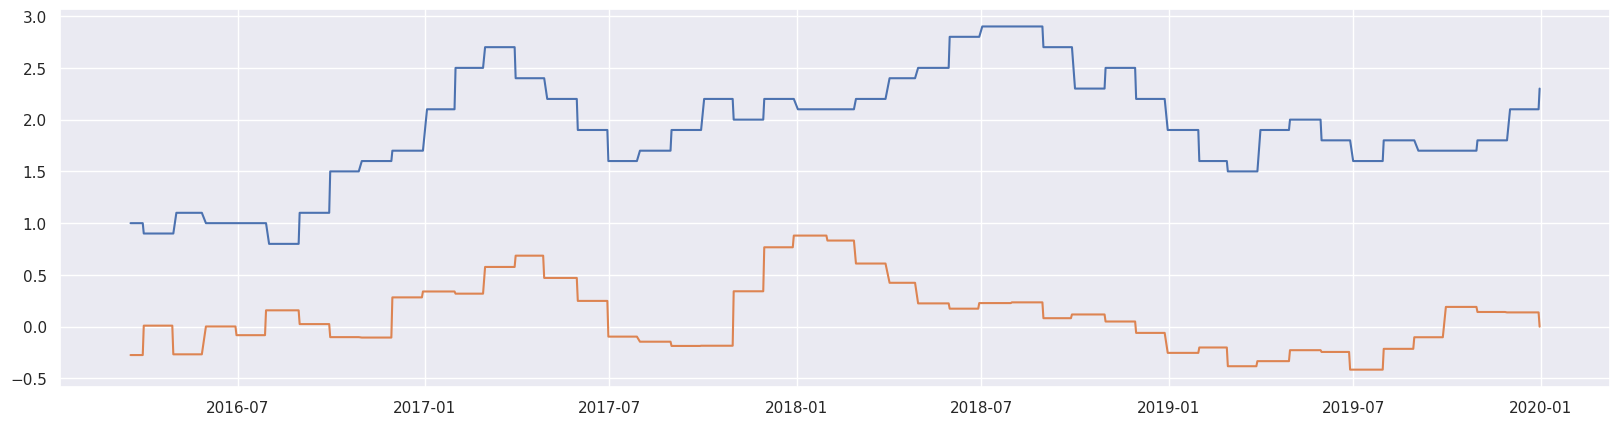

In [ ]:
plt.plot(df_sample['Inflation US'][n_train:])
plt.plot(df_sample['Surprise économique'][n_train:])

In [ ]:
from sklearn import metrics
def metrics_classification_report(expected, predicted, trends_model):
  df_metrics_report = pd.DataFrame(columns = [trends_model], index = ['Accuracy', 'F1', 'Precision','Recall'])
  df_metrics_report[trends_model]['Accuracy'] = metrics.accuracy_score(expected, predicted)
  df_metrics_report[trends_model]['F1'] = metrics.f1_score(expected, predicted)
  df_metrics_report[trends_model]['Precision'] = metrics.precision_score(expected, predicted)
  df_metrics_report[trends_model]['Recall'] = metrics.recall_score(expected, predicted)
  return df_metrics_report

In [ ]:
df_metrics = metrics_classification_report(Y_test_lagged_1, forecasted_labels, "Metrics")
df_metrics

,Metrics
Accuracy,0.678774
F1,0.684504
Precision,0.713953
Recall,0.657388


In [ ]:
def plot_confusion_matrix(df_confusion_matrix):
  fig = sns.heatmap(df_confusion_matrix, annot = True, fmt = 'g' )
  fig.set_xlabel('Actual trends')
  fig.set_ylabel('Predicted trends')
  fig.set_title('Confusion Matrix ')
  fig.xaxis.set_ticklabels(['Positives', 'Negatives'])
  fig.yaxis.set_ticklabels(['Positives', 'Negatives'])

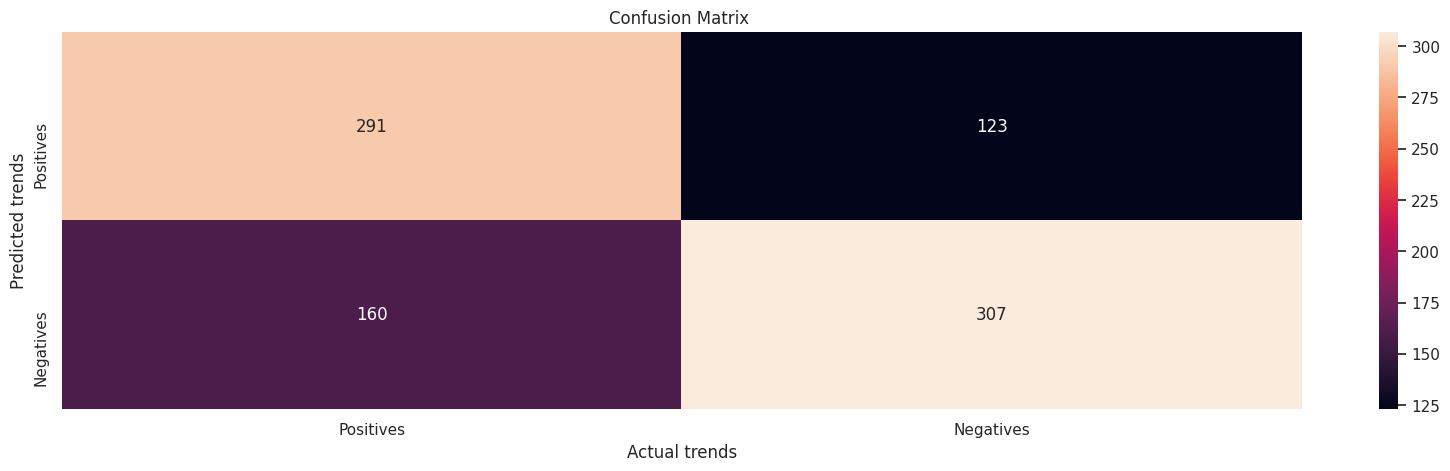

In [ ]:
plot_confusion_matrix(metrics.confusion_matrix(Y_test_lagged_1, forecasted_labels))

In [ ]:
sxp = df[['Closing Price']]
sxp.index.name = 'Days'
pred_lstm = df[['Closing Price Bot']]
pred_lstm.index.name = 'Days'
prob = pd.DataFrame(df.LSTM_prob * 10 + 110)
prob.index.name = 'Days'

In [ ]:
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CDSView, GroupFilter
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import EMPTY_LAYOUT

output_notebook()

sxp_col = ColumnDataSource(sxp)
pred_col = ColumnDataSource(pred_lstm)
prob_col = ColumnDataSource(prob)

# Create and configure the figure
fig = figure(plot_height=400, plot_width=1000,
             title='Trading Bot',
             x_axis_label='Trading Days', y_axis_label='Prediction',
             toolbar_location="right")

# Render the race as step lines
fig.line('Days', 'Closing Price', 
         color='red', legend_label='SXP Value',line_width=1.6, 
         source=sxp_col)

fig.line('Days', 'Closing Price Bot', 
         color='mediumblue', legend_label='LSTM Prediction', line_width=1.6,
         source=pred_col)

fig.line('Days', 'LSTM_prob', 
         color='darkgreen', legend_label='LSTM Proba', line_width=1.6, line_dash=[5],
         source=prob_col)

# Move the legend to the upper left corner
fig.legend.location = 'bottom_right'

# Show the plot
show(fig)
